# Netflik Film Recommender System

## Overview

For many streaming services there is an overwhelming amount of content. Customers may search fruitlessly through thousands of titles only to pick a movie they ultimately don't enjoy. When the initial search begins to feel inconvenient to a customer, Netfilk Film Corp is at risk of losing that client's interest and eventually their business. We designed a predictive algorithm will learn the preferences of each user and build them a profile, which can then be compared to users with similar profiles who have watched and rated some of the same and other similar films. Using the'surprise' package from sklearn with a algorithmic technique called Collaborative Filtering, our system will make recommendations to each user for new, unwatched films based on how highly similar users have rated that film. To maximize convenience, with the customers valuable time in mind, our system is designed to deliever 5 tailor-made recommendations, thus eliminating the need to scroll through endless content to find a film they may enjoy.

## Business Problem

The stakeholders are the new shareholders at the Netflik Film Corp, as they've invested in this new online streaming service. The streaming service provides a personalized experience for every customer by employing the most advanced algorithms and techniques for recommending only the films that are most likely to interest each user. This system builds profiles for each user and then identifies the particular interestes of each user based on the ratings the user provides (on a scale from 0.5 - 5) for each movie they watch. We theorize that similar user profiles will have similar tastes, therefore if our system recognizes that a customer has not seen a film that similar users have rated highly, then our system will recommend that the user watches that film.

We have distilled the search process from thoousands of titles to 5, which allows the user an efficient way to select a movie they are likely to enjoy. Of course, there is the possibility that the user does not like the film they choose from our system's recommendation list, in which case we highly encourage that user to rate that film fairly (and lower) so our system can better adapt to their taste. Because our system relies so heavily on user ratings for input, we have made the rating process as simple as pushing a button as soon as the user finishes their film - that way we our recommendation system can learn from as much data as possible about a user. To address the cold-issue that accompanies a system like this, upon starting a subscription, we ask that all new users rate popular films that tey have seen, to give our system a jump start on making custom recommendations. 

In order to measure the success of our model, we iterated through many options, tuning specifc hyperparameters along the way, until we achieved the lowest RMSE (Root Mean Squared Error). We chose this metric because it is easily interpreted as a value in the same units (within the rating scale) and can be measured for all of the model types that we built. For instance a RMSE of 1.0 would imply that a model consistently predicts a user's rating of an unseen film within 1.0 rating point of the actual rating the user would give the film. The 'surprise' package includes many model options: we established a baseilne RMSE score using the NormalPredictor model which we then compared to model iterations generated using more robust models like Singular Value Decomposition (SVD), NMF, and SVDpp model types. Ultimately, we detemrined that the SVD model with optimized paramters (detailed below) resulted in the lowest RMSE, and therefore is the best model to employ to make our predictions. This model was input into our custom recommendation function which generates a tailored list of 5 film recommendations, none of which should have already been viewed by the user. 

## Data Understanding

The data for this project comes from the [MovieLens](https://grouplens.org/datasets/movielens/latest/) dataset provided by the grouplens website. Specifically, we are working with the smaller dataset available on the website, which contains 4 csv files detailing user ratings for a variety of movies. We worked with two of the csv files for our project: the 'ratings.csv' file and the 'movies.csv' file, but we explored each of the four options first to determine which would be needed for designing our recommendation system. Here is a brief description of each of the files available:

- The 'ratings.csv' file contains just over 100,000 user rating records from 610 unique users. This is the primary resource we used when biulding our recommendation system. Among the 610 unique users, there is a wide range of inputs, with the highest total number of films rated reaching 2698 and the lowest being 20. For users with more ratings, our system was better able to recognize preferences, leading to recommendations that are more likely to appeal to the user. 

- The 'movies.csv' file contains records of 9,742 films, their title and year produced, and any genre categories that they fall into. This file's information was converted into a dataframe and merged with the 'ratings.csv' dataframe in order to assign the correct movie titles to the user's ratings via their shared 'movieId' column information.

- The 'tags.csv' file contains short snippets of user sentiment that could be analyzed via NLP modeling, but it is currently out of the scope of this project's goals. 

- The 'links.csv' file contains the identifing information used by separate movie data storage websites including imdb and tmbd. This information could be useful for a stretch goal of building a content-based recommendation system, as these other websites could porvide information that we would use for features. 



In [6]:
# First we run our imports, including pandas and all the model types we will use.
import pandas as pd
import numpy as np

# Models and scoring metric we will employ
from surprise import SVD, KNNBasic, NMF, SVDpp, accuracy 

# Necessary imports for converting information stored in a dataframe to a usable 'surprise' format
from surprise import Dataset, Reader 

# Imports for splitting our data and evaluating the model we chose before introducing the testing data
from surprise.model_selection import cross_validate, GridSearchCV, train_test_split

# Necessary for establishing a baseline model as a starting point
from surprise.prediction_algorithms import NormalPredictor

# For basic EDA purposes
import matplotlib.pyplot as plot

#### EDA: Exploring the 4 Provided Data Files

> #### The 'ratings.csv' was reviewed first:

In [7]:
# This file contains over 100,000 ratings made by 610 unique users
ratings_df = pd.read_csv('../data/ratings.csv')
ratings_df

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [8]:
# There appears to be no null values in this file
# The 'timestamp' column does not appear to be useful for our purposes and will likely be dropped later.
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


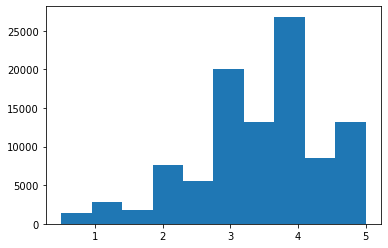

In [9]:
# It appears that there is a slight skew in the ratings distirbution with users appearing to favor higher ratings ~ 4.0
plot.hist(ratings_df['rating']);

> #### Second, we reviewed the 'movies.csv'

In [10]:
# There are 9742 unique movie records contained in this file along with genre categories listed 
movies_df = pd.read_csv('../data/movies.csv')
movies_df

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [11]:
# There are no null values in this file either
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


> #### Third we explored the 'tags.csv'

In [12]:
# This file contains sentiment from users contained in short phrases or sinlge words. We will not be including this information our model.
tags_df = pd.read_csv('../data/tags.csv')
tags_df

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200
...,...,...,...,...
3678,606,7382,for katie,1171234019
3679,606,7936,austere,1173392334
3680,610,3265,gun fu,1493843984
3681,610,3265,heroic bloodshed,1493843978


> #### Finally, we explored the 'links.csv'

In [13]:
# Similar to the 'tags.csv' this file contains data that is currently out of the scope of our project, but we will refer to it in our 
#     Next Steps, so we wanted to include it in the notebook.
links_df = pd.read_csv('../data/links.csv')
links_df

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0
...,...,...,...
9737,193581,5476944,432131.0
9738,193583,5914996,445030.0
9739,193585,6397426,479308.0
9740,193587,8391976,483455.0


#### Merging the Ratings data and Movies data

> We merged the ratings_df and movies_df dataframes so we can have the combined data feed into our function to complete the recommendation system. We then created a .csv version of the dataframe so we can reload it in the correct format for Surprise.

In [14]:
# Merge ratings and movies df's
merged_df = pd.merge(ratings_df, movies_df, on='movieId', how='right')

In [15]:
# Checking that the merge appears to have happened correctly, which it did but a few nulls were created and need to be addressed
merged_df

,userId,movieId,rating,timestamp,title,genres
0,1.0,1,4.0,9.649827e+08,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5.0,1,4.0,8.474350e+08,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7.0,1,4.5,1.106636e+09,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15.0,1,2.5,1.510578e+09,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17.0,1,4.5,1.305696e+09,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
...,...,...,...,...,...,...
100849,184.0,193581,4.0,1.537109e+09,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
100850,184.0,193583,3.5,1.537110e+09,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
100851,184.0,193585,3.5,1.537110e+09,Flint (2017),Drama
100852,184.0,193587,3.5,1.537110e+09,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [16]:
# Checking for data types and nulls
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100854 entries, 0 to 100853
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  float64
 1   movieId    100854 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  float64
 4   title      100854 non-null  object 
 5   genres     100854 non-null  object 
dtypes: float64(3), int64(1), object(2)
memory usage: 5.4+ MB


In [17]:
# Identifying total number of null values due to a lack of user rating for a film
merged_df.isna().sum()

userId       18
movieId       0
rating       18
timestamp    18
title         0
genres        0
dtype: int64

In [18]:
# Dropping null values
merged_df = merged_df.dropna()

In [19]:
# Checking that the nulls were properly dropped
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100836 entries, 0 to 100853
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  float64
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  float64
 4   title      100836 non-null  object 
 5   genres     100836 non-null  object 
dtypes: float64(3), int64(1), object(2)
memory usage: 5.4+ MB


In [20]:
merged_df['rating'].value_counts()

4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: rating, dtype: int64

In [21]:
# Creating a csv file that can be reloaded into the correct 'surprise' format
merged_df.to_csv('../data/ratings_and_movies.csv', index=False)

In [22]:
# Specifying the only columns we'll need for the modeling phase of the project
user_item_rating = merged_df[['userId', 'movieId', 'rating']]

In [23]:
# Creating another csv file that can be reloaded into the correct 'surprise' format
user_item_rating.to_csv('../data/user_item_rating.csv', index=False)

## Modeling

We began the modeling phase of our project by establishing a baseline model that we can later use for comparison when we generate RMSE values for each new model iteration. The baseline model we chose is the NormalPrdictor option from the 'surprise' package and we expect it will not perform too well when modeling the data, as it does not take into account some of the more complex algorithmic functions that the later models employ. We chose three other model types to explore after analyzing our baseline results, they are: the SVD model, an NMF model and finally the SVDpp model. For each model type we attempted to optimize the model's hyperparameters via a GridSearch with cross validation. This allowed us to test many hyperparamter options more efficiently than if we had to instantite and build a totally new model every time we wanted to test a specific set of hyperparameters. 

*The only downside to this approach to model optimization, is that grid-searching can be a very slow process to run, which can feel like it is slowing project progress, when it is actually still saving time compared to the manual approach for building each and every unique set of model hyperparameter options. GridSearchCV also has built in methods that allow us to see which parameters are optimal, in other words, which set of parameters generate the lowest RMSE for each model type. For certain model types we chose to run additional grid searches, which we have justified below - All done in hopes of building the best model as indicated by the RMSE score.

We will begin the cross validation process by splitting our data using the train_test_split function specific to the 'surprise' package. Because we do not have a 'target' for this type of model, we do not need to specify a 'y' value, rather we just need to set aside some data so the model can be tested when introduced to 'new' data. 

### Baseline Model Placeholder
NormalPredictor - may give the biggest "improvement"

### SVD: First Complex Model

We chose to then use the Singular Value Decompostion model type to begin our more-complex recommendation system, because an SVD model is categorized as a latent factor model that generates recommendations using specifc user inputs (ratings) tied to specifc items (movies in this case). The SVD model performs matrix factorization without the need for additional setup other than feeding the model a dataset simply consisting of the user identifier (userId), the item identifier (movieId), and the user rating input (rating).

We will continue to analyze the RMSE value in comparison to our baseline model.

In [41]:
# Setting up for our modelling process begins with instantiating a 'Reader' that allows our data to be used by the 'surprise' model types
reader = Reader(line_format='user item rating', sep=',', skip_lines=1, rating_scale=(1, 5))

# Reading in our data into a 'surprise' Dataset format
ratings_surprise = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)

In [42]:
# Spliting our data so we can train our model on testing data before introducing new data (test data) to measure performance on unseen data
trainset, testset = train_test_split(ratings_surprise, test_size=0.2, random_state=42)

In [43]:
print('Number of users: ', trainset.n_users, '\n')
print('Number of items: ', trainset.n_items, '\n') # It appears some films were not included in the train set because they were not rated

Number of users:  610 

Number of items:  8928 



For the first iteration of the SVD model, we will use the standard established parameters. 

In [44]:
svd = SVD()
svd.fit(trainset)

In [45]:
preds = svd.test(testset)

In [46]:
rmse = accuracy.rmse(preds)
mae = accuracy.mae(preds)

RMSE: 0.8787
MAE:  0.6765


#### SVD First Iteration Evaluation: 
This model performed better than the baseline model with an RMSE reduction of (""), meaning that this model more accurately predicts the ratings that a user would give a film if they were to watch it.

### SVD: Grid Search #1

The initial model performed better than the baseline, but we wanted to tune the given hyperparameters to optimize the model and see if we can acheive an even lower RMSE. In particular, we chose to tune the following hyperparameters for these reasons:
- 'n_factors':

- 'reg_all':

- 'n_epochs': This hyperparamter refers to the number of iterations that the model is 

In [30]:
params = {'n_factors': [20, 25, 50, 100],
         'reg_all': [0.02, 0.03, 0.04, 0.05, 0.06, 0.07], 'n_epochs': [20, 25, 30, 35]}
g_s_svd = GridSearchCV(SVD,param_grid=params,n_jobs=-1, cv=3)
g_s_svd.fit(ratings_surprise)

KeyboardInterrupt: 

In [ ]:
# We are able to determine the best set of parameters by calling this method on the model
g_s_svd.best_params['rmse']

In [ ]:
# Cross validate
results = cross_validate(svd, ratings_surprise, measures=['RMSE'], cv=3, n_jobs = -1, verbose=True)

In [31]:
# Re-doing the SVD model with the best params from the GridSearchCV
svd_bestparams = SVD(n_factors=100, n_epochs=30, biased=True, reg_all=0.07, random_state=42)

svd_bestparams.fit(trainset)
predictions = svd_bestparams.test(testset)
svd_gs1 = accuracy.rmse(predictions)

RMSE: 0.8693


In [48]:
# Subtracting the RMSE scores from the first iteration and the iteration determined by the grid search
0.8787 - 0.8693

0.009400000000000075

#### SVD: Grid Search #1 Evaluation: 

- The RMSE score is very slightly better than the score of the baseline model with nothing tuned and results in an RMSE of .0094 less than the original SVD() model.

Hyperparameter Analysis:
- n_factors: 100 was the highest n_factor value we allowed the grid search to implement, because this came out as the optimal value, we will want to see if increasing this number could further optimize in later iterations
- n_epochs: 30 appears to be the best value here, and this number fell within the middle of the hyperparameter grid options, so we will keel this value 
- biased:
- reg_all: .07 is at the highest end of the hyperparameter options implemented, so we will test additional, higher values in the nxt GS.

### SVD: Grid Searches # 2 - 4

For the second round of grid-searching we will focus on the higher values for n_factors and reg_all and we will keel the n_epochs the same becasue it appears to have optimized. 
- We added the lr_all hyperparameter to this grid search because...

In [ ]:
params = {'n_factors': [100, 125, 150],
         'reg_all': [0.07, 0.08], 'n_epochs': [30], 'lr_all': [0.02, 0.05]}
g_s_svd2 = GridSearchCV(SVD,param_grid=params,n_jobs=-1, cv=3)
g_s_svd2.fit(ratings_surprise)

In [ ]:
g_s_svd2.best_params['rmse']

In [ ]:
params = {'n_factors': [150, 175, 200],
         'reg_all': [0.07, 0.08, 0.09, 0.1], 'n_epochs': [30], 'lr_all': [0.01, 0.02]}
g_s_svd3 = GridSearchCV(SVD,param_grid=params,n_jobs=-1, cv=3)
g_s_svd3.fit(ratings_surprise)

In [ ]:
g_s_svd3.best_params['rmse']

In [ ]:
params = {'n_factors': [200, 300, 500],
         'reg_all': [0.1, 0.3, 0.5], 'n_epochs': [30], 'lr_all': [0.02]}
g_s_svd4 = GridSearchCV(SVD,param_grid=params,n_jobs=-1, cv=3)
g_s_svd4.fit(ratings_surprise)

In [ ]:
g_s_svd4.best_params['rmse']

In [ ]:
params = {'n_factors': [1, 500, 1000, 1500],
         'reg_all': [0.1], 'n_epochs': [30], 'lr_all': [0.02]}
g_s_svd5 = GridSearchCV(SVD,param_grid=params,n_jobs=-1, cv=3)
g_s_svd5.fit(ratings_surprise)

In [ ]:
g_s_svd5.best_params['rmse']

In [32]:
svd_bestparams2 = SVD(n_factors=500, n_epochs=30, biased=True, reg_all=0.1, lr_all=0.02, random_state=42)

svd_bestparams2.fit(trainset)
predictions = svd_bestparams2.test(testset)
svd_gs2 = accuracy.rmse(predictions)

RMSE: 0.8568


~Model Evaluation/Comments

- This is the lowest RMSE score we acheived using the SVD model.

### Second Model Type: KNN

In [33]:
#KNN
#sim = {'user_based': True, 'name': 'pearson'}
#KNN = KNNBasic(sim_options=sim)

In [34]:
#trainset, testset = train_test_split(ratings_surprise, test_size=0.2, random_state=42)

In [35]:
#KNN.fit(trainset)

Computing the pearson similarity matrix...
Done computing similarity matrix.


### NMF: Second Complex Model

In [51]:
# Instantiating the model with the standard hyperparameters
nmf = NMF()

In [52]:
# Fitting the model to the training data
nmf.fit(trainset)

In [53]:
# Generating predictions using the testing data
nmf_preds = nmf.test(testset)

In [55]:
# Checking the RMSE for this model
rmse_nmf = accuracy.rmse(nmf_preds)

RMSE: 0.9280


>For our first attempt at tuning we decided to explore the best parameters that we found for the SVD model and applied them to our design of the first NMF model as a starting point.

In [40]:
NMF_bestparamsSVD = NMF(n_factors=500, n_epochs=30, biased=True, random_state=42)

In [41]:
NMF_bestparamsSVD.fit(trainset)

In [42]:
nmf_preds2 = NMF_bestparamsSVD.test(testset)

In [43]:
rmse_nmf2 = accuracy.rmse(nmf_preds2)
print("RMSE (NMF):", rmse_nmf2)

RMSE: 1.8088
RMSE (NMF): 1.8087746792544073


In [ ]:
params = {'n_factors': [10, 100, 500],
         'n_epochs': [75, 100, 135]}
g_s_nmf1 = GridSearchCV(NMF,param_grid=params,n_jobs=-1, cv=3)
g_s_nmf1.fit(ratings_surprise)

In [ ]:
g_s_nmf1.best_params['rmse']

In [44]:
NMF2 = NMF(n_factors=500, n_epochs=100, biased=True, random_state=42)

In [45]:
NMF2.fit(trainset)

In [46]:
nmf_preds3 = NMF2.test(testset)

In [47]:
rmse_nmf3 = accuracy.rmse(nmf_preds3)
print("RMSE (NMF):", rmse_nmf3)

RMSE: 1.9353
RMSE (NMF): 1.9353167735262842


### SVD++

In [48]:
svdpp = SVDpp()

In [49]:
svdpp.fit(trainset)

In [50]:
preds_svdpp = svdpp.test(testset)

In [51]:
rmse_svdpp = accuracy.rmse(preds_svdpp)
print("RMSE (SVD++):", rmse_svdpp)

RMSE: 0.8689
RMSE (SVD++): 0.8688701924247805


In [52]:
svdpp_bestparams = SVDpp(n_factors=25, n_epochs=30, reg_all=0.1, lr_all=0.02, random_state=42)

svdpp_bestparams.fit(trainset)
predictions = svdpp_bestparams.test(testset)
svdpp_gs = accuracy.rmse(predictions)

RMSE: 0.8610


### Building a Function to Generate Film Recommendations

The next step in this project is to build a function that takes in a the optimal model's predictions and creates a list of all the movies that a user has not seen and then predicts the user's rating for these films. The function then produces the top 5 movies sorted by the highest predicted rating. 

Before the step-by-step function building process, we need to set the 'best_model' variable equal to the model with the lowest RMSE from above. 

In [54]:
# Setting the best_model to the model iteration with the lowest RMSE across all the models built.
best_model = svd_bestparams2

In [56]:
# Fitting the model to the trainset
best_model.fit(trainset)

NameError: name 'best_model' is not defined

In [57]:
# Creating a list from the 'ratings_df' dataframe that drops the 'rating' and 'timestamp' column, because we ONLY need this list to 
#      contain the user and movie identification information, as this indicates whether or not a user watched an rated a film.
watched_df = ratings_df.set_index('userId')
watched_df.drop(columns=['rating', 'timestamp'], inplace=True)
watched_df

,movieId
userId,
1,1
1,3
1,6
1,47
1,50
...,...
610,166534
610,168248
610,168250


In [ ]:
# Converting this new df into a CSV for storage and later access as needed.
watched_df.to_csv('../data/watched_df.csv')

In [266]:
# Setting a dynamic variable, that takes a userId as input to then gnerate the recommendations for that specific user
user = int(input('UserId: '))

UserId:  474


In [267]:
#Checking that the int() function properly cast the user variable as an integer so it can run through the function later
type(user)

int

In [250]:
# Taking the watched_df and and converting it to a list of movieId's only, so these can be dropped later as films that the user already saw
watched_list = list(watched_df.loc[user, 'movieId'])
len(watched_list)  # sanity checking that they list contains all the movies that a user watched

2108

In [252]:
# Creating a list of movies that the user HAS NOT seen begins with copying the movies dataframe and reset the index to the 'movieId' column
unwatched_list = movies_df.copy()
unwatched_list = movies_df.set_index('movieId')
unwatched_list

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy
...,...,...
193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
193585,Flint (2017),Drama


In [259]:
unwatched_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7634 entries, 0 to 7633
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  7634 non-null   int64 
 1   title    7634 non-null   object
 2   genres   7634 non-null   object
dtypes: int64(1), object(2)
memory usage: 179.0+ KB


In [254]:
# Dropping the list of watched movies using the movieId column
unwatched_list.drop(watched_list, inplace=True)
unwatched_list.reset_index(inplace=True) #replacing the index in the dataframe
unwatched_list.head() # displaying the first 5 titles to ensure it worked

,movieId,title,genres
0,3,Grumpier Old Men (1995),Comedy|Romance
1,4,Waiting to Exhale (1995),Comedy|Drama|Romance
2,8,Tom and Huck (1995),Adventure|Children
3,9,Sudden Death (1995),Action
4,10,GoldenEye (1995),Action|Adventure|Thriller


In [255]:
# Checking again to ensure that we dropped the proper number of watched films
len(movies_df) - len(unwatched_list)

2108

In [268]:
# Compiling all the steps detailed above into a single fucntion!

def movie_recommender():
    
    user = int(input('userId:'))

    watched_list = list(watched_df.loc[user, 'movieId'])
    unwatched_list = movies_df.copy()
    unwatched_list = movies_df.set_index('movieId')
    unwatched_list.drop(watched_list, inplace=True)
    unwatched_list.reset_index(inplace=True)
    unwatched_list['pred_rating'] = unwatched_list['movieId'].apply(lambda i: best_model.predict(user, i).est)
    unwatched_list.sort_values(by='pred_rating', ascending=False, inplace=True)
    
    return unwatched_list.head()

#### Function Testing: 

- The function appears to cleaning and easily take in a userId as input and then generate a list of the top 5 movies that the model predicts this user will rate the highest.

- Below we've generated a few user recommendations to explore their differences and hyptohesize about why these differneces may have occured.

In [79]:
# Checking the recommendations for user 474
movie_recommender()

userId: 474


,movieId,title,genres,pred_rating
7510,177593,"Three Billboards Outside Ebbing, Missouri (2017)",Crime|Drama,4.314493
421,741,Ghost in the Shell (Kôkaku kidôtai) (1995),Animation|Sci-Fi,4.262250
1518,3275,"Boondock Saints, The (2000)",Action|Crime|Drama|Thriller,4.243491
4604,58559,"Dark Knight, The (2008)",Action|Crime|Drama|IMAX,4.190657
6358,112552,Whiplash (2014),Drama,4.181801


In [65]:
# Checking the recommendations for user 610
movie_recommender()

userId:  610


,movieId,title,genres,pred_rating
827,1204,Lawrence of Arabia (1962),Adventure|Drama|War,4.382414
810,1178,Paths of Glory (1957),Drama|War,4.364607
772,1104,"Streetcar Named Desire, A (1951)",Drama,4.328158
805,1172,Cinema Paradiso (Nuovo cinema Paradiso) (1989),Drama,4.327683
8316,177593,"Three Billboards Outside Ebbing, Missouri (2017)",Crime|Drama,4.314493


In [269]:
# Checking the recommendations for user 2
movie_recommender()

userId: 2


,movieId,title,genres,pred_rating
2579,3451,Guess Who's Coming to Dinner (1967),Drama,4.520722
935,1237,"Seventh Seal, The (Sjunde inseglet, Det) (1957)",Drama,4.424485
9589,177593,"Three Billboards Outside Ebbing, Missouri (2017)",Crime|Drama,4.396874
678,898,"Philadelphia Story, The (1940)",Comedy|Drama|Romance,4.387048
1419,1945,On the Waterfront (1954),Crime|Drama,4.384074


#### Function Evaluation:

- Each user has a unique set of 5 recommended movies. This optimal model has learned what a user prefers via their ratings and compared their compiled profile to that of similar users in order to predict a rating for an unwatched movie that our system is recommending to them.

### Building a Function to Generate User Profile Information:
- This second fucntion will act as a way to check if the generated recommendations are appropriate for a given user:

In [1]:
# Copying the merged dataframe to begin teh function building process
profile = merged_df.copy()
profile

NameError: name 'merged_df' is not defined

In [218]:
user=610 # for testing purposed, defining a specific user
profile = merged_df.loc[merged_df['userId'] == user, ['userId', 'title', 'rating']] # Pulling ONLY relavent columns
profile

,userId,title,rating
214,610.0,Toy Story (1995),5.0
534,610.0,Heat (1995),5.0
954,610.0,Casino (1995),4.5
1678,610.0,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),4.5
2309,610.0,Seven (a.k.a. Se7en) (1995),5.0
...,...,...,...
100250,610.0,Split (2017),4.0
100312,610.0,John Wick: Chapter Two (2017),5.0
100327,610.0,Get Out (2017),5.0
100352,610.0,Logan (2017),5.0


In [207]:
profile.set_index('userId', inplace=True)
profile

,title,rating
userId,,
610.0,Toy Story (1995),5.0
610.0,Heat (1995),5.0
610.0,Casino (1995),4.5
610.0,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),4.5
610.0,Seven (a.k.a. Se7en) (1995),5.0
...,...,...
610.0,Split (2017),4.0
610.0,John Wick: Chapter Two (2017),5.0
610.0,Get Out (2017),5.0


In [196]:
profile.sort_values(by='rating', ascending=False, inplace=True)
profile

,title,rating
userId,,
610.0,Toy Story (1995),5.0
610.0,In Bruges (2008),5.0
610.0,Blue Velvet (1986),5.0
610.0,"Bourne Ultimatum, The (2007)",5.0
610.0,John Wick (2014),5.0
...,...,...
610.0,Stan Helsing (2009),1.0
610.0,Taken 3 (2015),1.0
610.0,Derailed (2002),0.5


In [4]:
user = 610
profile_ = merged_df.copy()
profile_ = merged_df.loc[merged_df['userId'] == user, ['userId', 'title', 'rating']]
profile_.set_index('userId', inplace=True)
profile_.sort_values(by='rating', ascending=False, inplace=True)
profile_.reset_index(inplace=True) # resetting the index to the 'ranking' of the movies, although all the movies with the same rating are not ordered
profile_

NameError: name 'merged_df' is not defined

In [3]:
# Practicing the format for a print out
print(f'Profile for User: {user}')
print('______________________________')
print('Highest rated films by User (Rated 5):')
print(profile['title'][0])
print(profile['title'][1])
print(profile['title'][2])
print(profile['title'][3])
print(profile['title'][4])

NameError: name 'user' is not defined

In [2]:
# Combining all previous steps into a single function:
def profile_builder():

    user = int(input('Profile for User: '))
    
    profile = merged_df.copy()
    profile = merged_df.loc[merged_df['userId'] == user, ['userId', 'title', 'rating']]
    profile.set_index('userId', inplace=True)
    profile.sort_values(by='rating', ascending=False, inplace=True)
    profile.reset_index(inplace=True)

    print('====================================')
    print('Highest rated films by User (Rated 5):')
    print('====================================')
    print(profile['title'][0])
    print(profile['title'][1])
    print(profile['title'][2])
    print(profile['title'][3])
    print(profile['title'][4])

In [29]:
profile_builder()

Profile for User:  474


Highest rated films by User (Rated 5):
Lord of the Rings: The Two Towers, The (2002)
Sophie Scholl: The Final Days (Sophie Scholl - Die letzten Tage) (2005)
Spider-Man 2 (2004)
Star Wars: Episode V - The Empire Strikes Back (1980)
Psycho (1960)
Crossing Delancey (1988)
Much Ado About Nothing (1993)
Lady Jane (1986)
Gaslight (1944)
Sixth Sense, The (1999)


#### Function(s) Evaluations:
- The recommender function works well to generate a list of 5 movies that a user shoul denjoy according to the similar taste of comparable user profiles.
- The profile function acts to help us check if the recommendations would fit for the user. For instance if a user appears to enjoy a certain type of film genre and rates those movies highly often, then we would expect to see that film genre to be in the recommendations list!

## Conclusions

#### Nest Steps
- Build a Content-Based model to bolster the results from the Collaborative Filtering model
- Incentivize users to rate the films they watch
- Illicit responses from users, regarding their perception of the 5-film recommender system

The Recommendation System we've built will successfully generate a list of 5 films that a user is predicted to rate highly if they were to watch based on a user-user comparison of ratings provided by existing users. Netflik could effectively deploy this model for all it's users to help conveniently narrow down the multitude of content options offered to their customers. This system is currently limited to generating only 5 recommendations at a time, however it could be easily ammended to generate any specific number of films, if needed. An additional content-based system would be a logical next step if more time was allowed, as this additional model could work in conjunction with the curernt Collaboratibve Filtering model through genre feature analysis to add complexity. 